<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book2/28/hmm_gauss2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HMM with 2d Gaussian emissions 

We use the [ssm-jax](https://github.com/probml/ssm-jax/blob/main/ssm_jax/) library.


In [1]:
try:
    import ssm_jax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    import ssm_jax


import ssm_jax.hmm.demos.gaussian_hmm_2d as demo

import numpy as np
import jax.numpy as jnp
import jax.random as jr

import matplotlib.pyplot as plt

In [2]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [3]:
true_hmm = demo.make_hmm()
num_timesteps = 2000
plot_timesteps = 200
true_states, emissions = true_hmm.sample(jr.PRNGKey(0), num_timesteps)

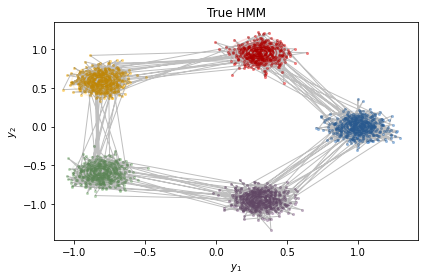

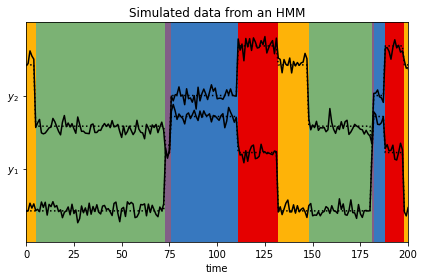

In [4]:
demo.plot_gaussian_hmm(true_hmm, emissions, true_states, "True HMM")
plt.savefig("hmm_gauss_2d_emissions.pdf")

demo.plot_gaussian_hmm_data(true_hmm, emissions, true_states, xlim=(0, plot_timesteps))
plt.savefig("hmm_gauss_2d_trace.pdf")

plt.show()